In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = True

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# load model
model = LeNet5().eval()
model.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))
model = model.to(device)

# test model
dset.test(model, test_loader, args)
model = model.to('cpu')


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)



# autoencoder

In [3]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.fc1 = nn.Linear(4*8*8, 20)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv3 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)
        self.fc2 = nn.Linear(20, 4*8*8)
        
    def encode(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)   
        x = self.fc1(x.view(-1, 4*8*8))
        return x
        
    def decode(self, x):
        # upsample, followed by a conv layer, with relu activation function  
        # upsample again, output should have a sigmoid applied
        x = self.fc2(x).view(-1,4,8,8)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv3(x))     
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv4(x))                  
        return x
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.encode(x)
        x = self.decode(x)  
        return x

# initialize the NN
model_a = ConvAutoencoder().to(device)

# load model
model_a.load_state_dict(torch.load('./models/autoencoder/transform+fc'))

<All keys matched successfully>

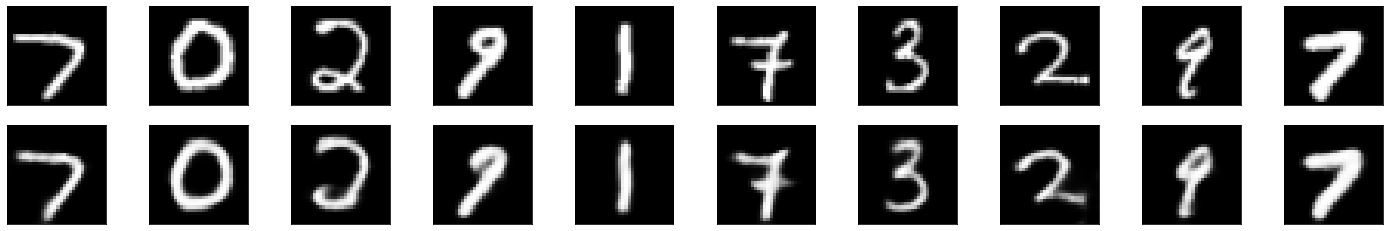

In [4]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[70:80]
model_a = model_a.to('cpu')

# get sample outputs
output = model_a(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(10, 1, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

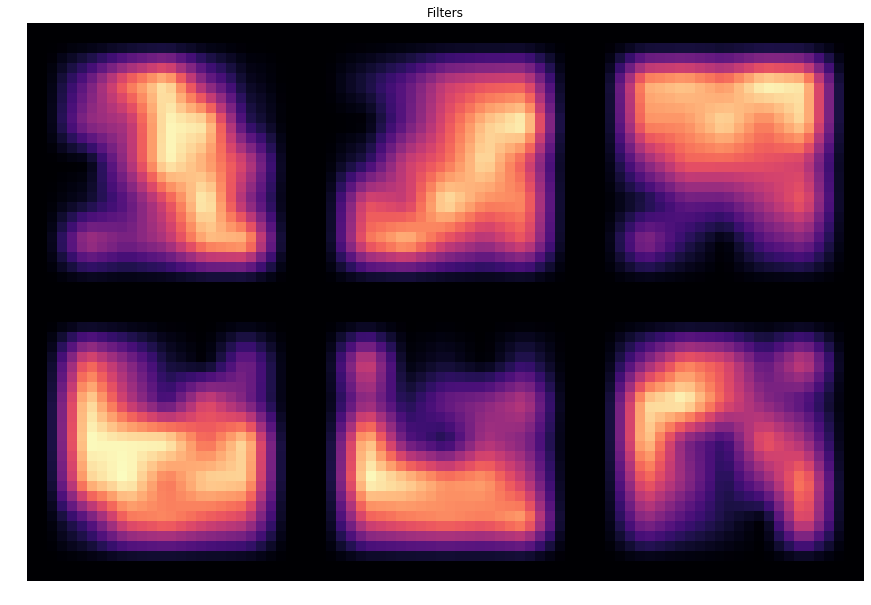

In [5]:
# viz filters
viz_tensors(model.convnet.c1.weight.squeeze(), n_row=2, n_col=3, normalize=True)

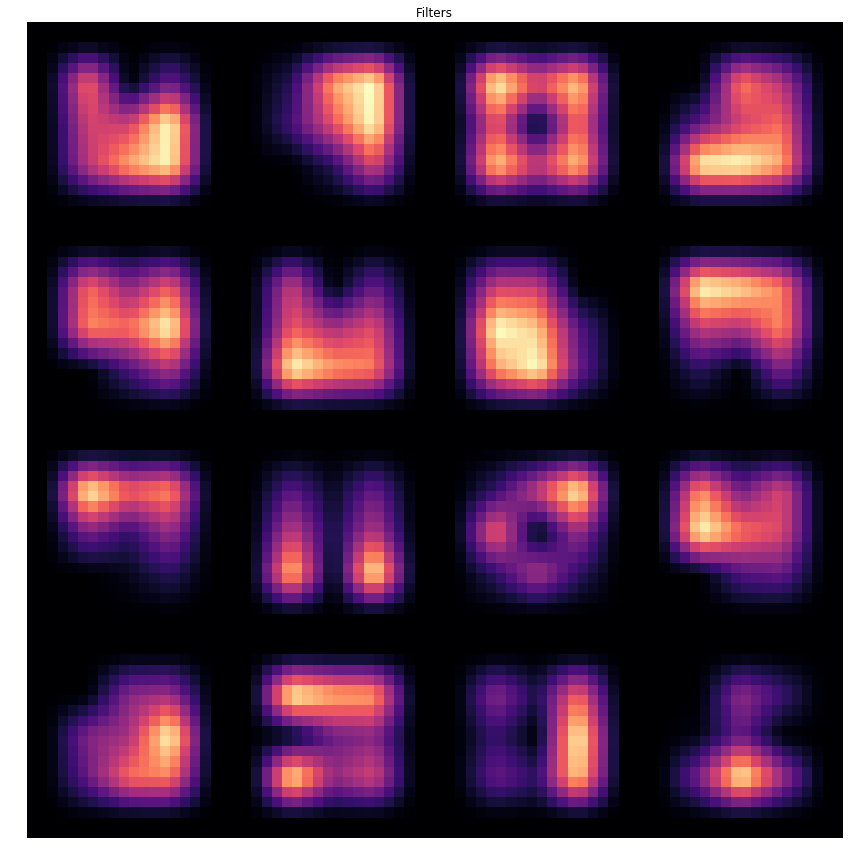

In [6]:
# viz filters
viz_tensors(model_a.conv1.weight.squeeze(), n_row=4, n_col=4, normalize=True)

In [7]:
images, labels = iter(test_loader).next()
images = images[:10]

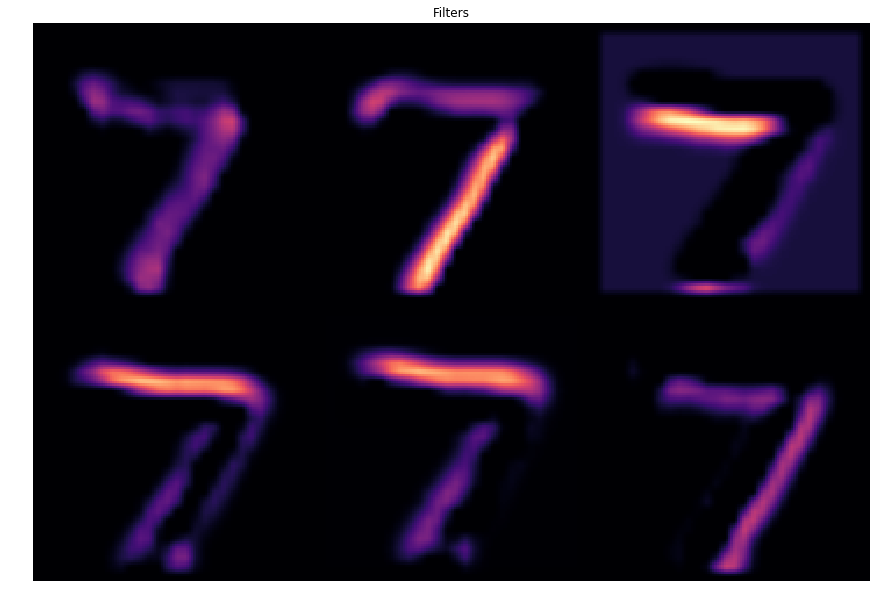

In [8]:
# viz filters
viz_tensors(F.relu(model.convnet.c1(images))[0], n_row=2, n_col=3, normalize=False)

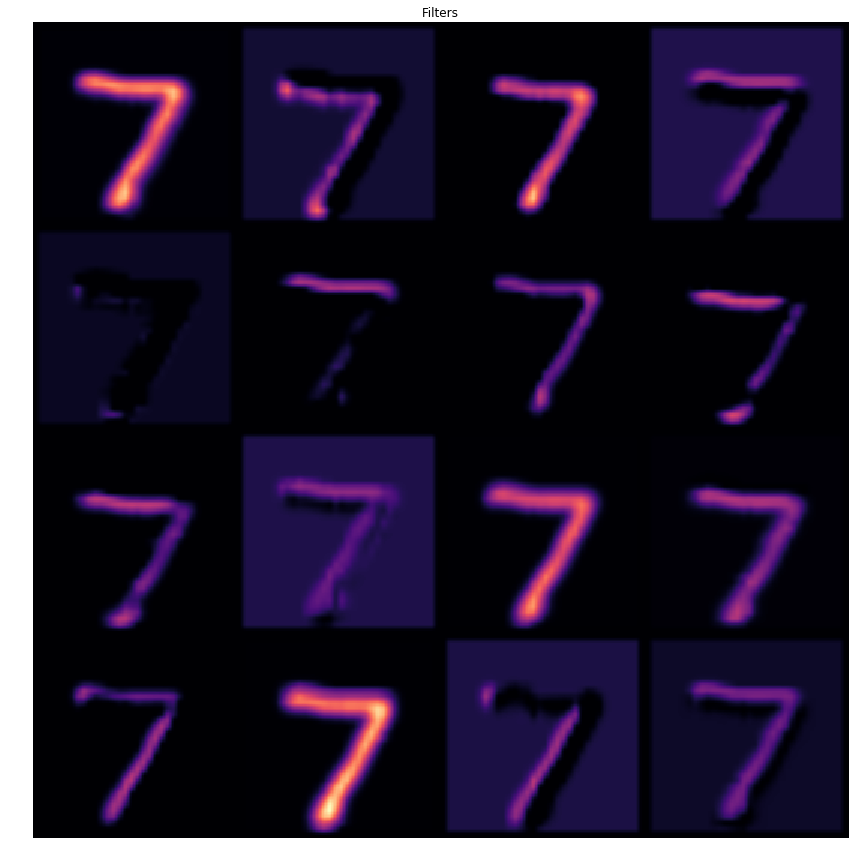

In [9]:
# viz filter
viz_tensors(F.relu(model_a.conv1(images))[0], n_row=4, n_col=4, normalize=False)

## TRIM interp

In [10]:
# transform
t = lambda x: F.relu(model_a.conv1(x))
transform_i = lambda x: model_a.decode(model_a.encode(x))

# prepend model
m_t = TrimModel(model, transform_i, use_residuals=True)

In [15]:
# data
images, labels = iter(test_loader).next()
images = images[:10]
labels = labels[:10]

# get attributions
m_t.x_orig = deepcopy(images)
inputs_t = t(images)
# attributer = IntegratedGradients(m_t)
attributer = InputXGradient(m_t)
attributions = attributer.attribute(inputs_t, target=labels)

In [16]:
# data
images, labels = iter(test_loader).next()
images = images[:10]
labels = labels[:10]

# get attributions
m_t.x_orig = deepcopy(images)
inputs_t = t(images)
attributer = IntegratedGradients(m_t)
# attributer = InputXGradient(m_t)
attributions = attributer.attribute(inputs_t, target=labels)

RuntimeError: The size of tensor a (10) must match the size of tensor b (500) at non-singleton dimension 0

In [ ]:
# data
images, labels = iter(test_loader).next()
images = images[:10]
labels = labels[:10]

# get attributions
inputs_t = t(images)
m_t.use_residuals = True
attributer = IntegratedGradients(m_t)
attributions = attributer.attribute((inputs_t, deepcopy(images)), target=labels)
# attributions = attributer.attribute(inputs_t, target=labels, additional_forward_args=deepcopy(images))
# attributer = InputXGradient(m_t)
# attributions = attributer.attribute(inputs_t, target=labels)

In [ ]:
# autoencoder
viz_tensors(attributions[0][0], n_row=4, n_col=4, normalize=False)

In [ ]:
class LeNet55(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet55, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))
    
    def transform(self, img):
        output = self.convnet.relu1(self.convnet.c1(img))
        return output
        
    def forward(self, img):
        output = self.convnet.s2(img)
        output = self.convnet.relu3(self.convnet.c3(output))
        output = self.convnet.s4(output)
        output = self.convnet.relu5(self.convnet.c5(output))
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output
    
# load model
model0 = LeNet55().eval()
model0.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))

In [ ]:
# data
images, labels = iter(test_loader).next()
images = images[:10]
labels = labels[:10]

# get attributions
inputs_t = model0.transform(images)
# attributer = InputXGradient(model0)
attributer = IntegratedGradients(model0)
attributions = attributer.attribute(inputs_t, target=labels)

In [ ]:
# autoencoder
viz_tensors(attributions[0], n_row=2, n_col=3, normalize=False)